# Object Detection (Part 1 - Model Creation)

## Introduction

This ipynb notebook is created to document the results of my self-study in the topic of `object detection`.<br>
I simply create image dataset by using the stable diffusion model [anything-v4.0](https://huggingface.co/xyn-ai/anything-v4.0/tree/main) and do annotation by myself.

The images below showcase samples with their corresponding bounding boxes labeled as `Face`:

<div style="display: flex; justify-content: center;">
  <div style="margin: 5px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929489.png" style="max-height:300px;width:auto">
      <figcaption>Sample image 1</figcaption>
    </figure>
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929489_ROI.png" style="max-height:300px;width:auto">
      <figcaption>Sample image with ROI 1</figcaption>
    </figure>
  </div>
  <div style="margin: 5px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929490.png" style="max-height:300px;width:auto">
      <figcaption>Sample image 2</figcaption>
    </figure>
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929490_ROI.png" style="max-height:300px;width:auto">
      <figcaption>Sample image with ROI 2</figcaption>
    </figure>
  </div>
  <div style="margin: 5px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929491.png" style="max-height:300px;width:auto">
      <figcaption>Sample image 3</figcaption>
    </figure>
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929491_ROI.png" style="max-height:300px;width:auto">
      <figcaption>Sample image with ROI 3</figcaption>
    </figure>
  </div>
  <div style="margin: 5px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929494.png" style="max-height:300px;width:auto">
      <figcaption>Sample image 4</figcaption>
    </figure><figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929494_ROI.png" style="max-height:300px;width:auto">
      <figcaption>Sample image with ROI 4</figcaption>
    </figure>
  </div>
  <div style="margin: 5px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929498.png" style="max-height:300px;width:auto">
      <figcaption>Sample image 5</figcaption>
    </figure><figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/ObjectDetection/177929498_ROI.png" style="max-height:300px;width:auto">
      <figcaption>Sample image with ROI 5</figcaption>
    </figure>
  </div>
</div>

**Note:**
- This `.ipynb` notebook primarily demonstrates the complete coding cycle, covering the creation, training, and evaluation of the model.
- Later on, I found that my custom Keras metric `MeanAveragePrecision` in the `Model Training` section works on a batch-wise basis. As a temporary measure, I may exclude it. Once I address this in the code, I will revisit and update this Jupyter notebook.


# Programming

## Version

In [1]:
import sys
sys.dont_write_bytecode = True

from module.utility.Initializer import Initializer
# Display version of TensorFlow and Python
Initializer.show_version()

# Display Version of Nvidia Driver and CUDA
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Wed Nov 22 15:29:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0              21W /  80W |    277MiB /  6144MiB |      5%      Default |
|                                         |     

## Configuration

For this study, the following configurations will be used:

- **Mixed Precision (16-bit):** Disabled
- **Image Size:** 320x320 pixels
- **Batch Size:** 8 images
- **Label list:** `Face`
- **Number of Anchors:** 1 unit (since the dataset contains only 1 object with a similar bounding box size)
- **Optimizers:**
  - Main Training: Adam optimizer with a learning rate of 1e-4
  - Fine Tuning 1: Adam optimizer with a learning rate of 1e-5 and decay of 1e-4
  - Fine Tuning 2: Adam optimizer with a learning rate of 1e-6 and decay of 1e-4

In [2]:
import tensorflow as tf

CFG = {
    "fp16": False,
    "dataset_dir": "D:\Github Public\DATASET MANAGER\ObjectDetection_MINI",
    "image_size": 320, 
    "batch": 8, 
    "label": ["Face"],
    "anchor": 1,
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-4),
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-4),
    "optimizer3": tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-4),
}

## Initializing

In [3]:
if CFG["fp16"]:
    Initializer.mixed_precision16()

Initializer.memory_growth()

## Dataset Preparation

The dataset will be prepared in the form of a tuple list `[(image_path, xml_path), ...]` and be forwarded into my own implemented data generator, `YOLOv3DataGenerator`. This data generator is configured with the following image augmentations:

- Random horizontal flip
- Random translation for 10% of the image size (+/- 32 pixels)
- Random rotation within +/- 5 degrees angular range ※1

**Note:** <br>
※1 It's essential not to set the rotation degree too high, as it may impact the boundary box during annotation generation, leading to an oversize boundary box.


In [4]:
from module.utility.DirectoryProcessor import DirectoryProcessor

path_list = DirectoryProcessor.get_all_files(CFG["dataset_dir"], include_sub_dir=False)
path_list = [(path_list[i], path_list[i + 1]) for i in range (0, len(path_list), 2)]

Calculating anchor size ... 1 anchor box: [(0.49, 0.49)]
CALLING preprocessing function
READ IMAGE ... COMPLETE
READ XML ... COMPLETE
AUGMENTATION: translation -> rotation_complex -> horizontal_flip -> padding -> COMPLETE
Generate annotation labels ... COMPLETE


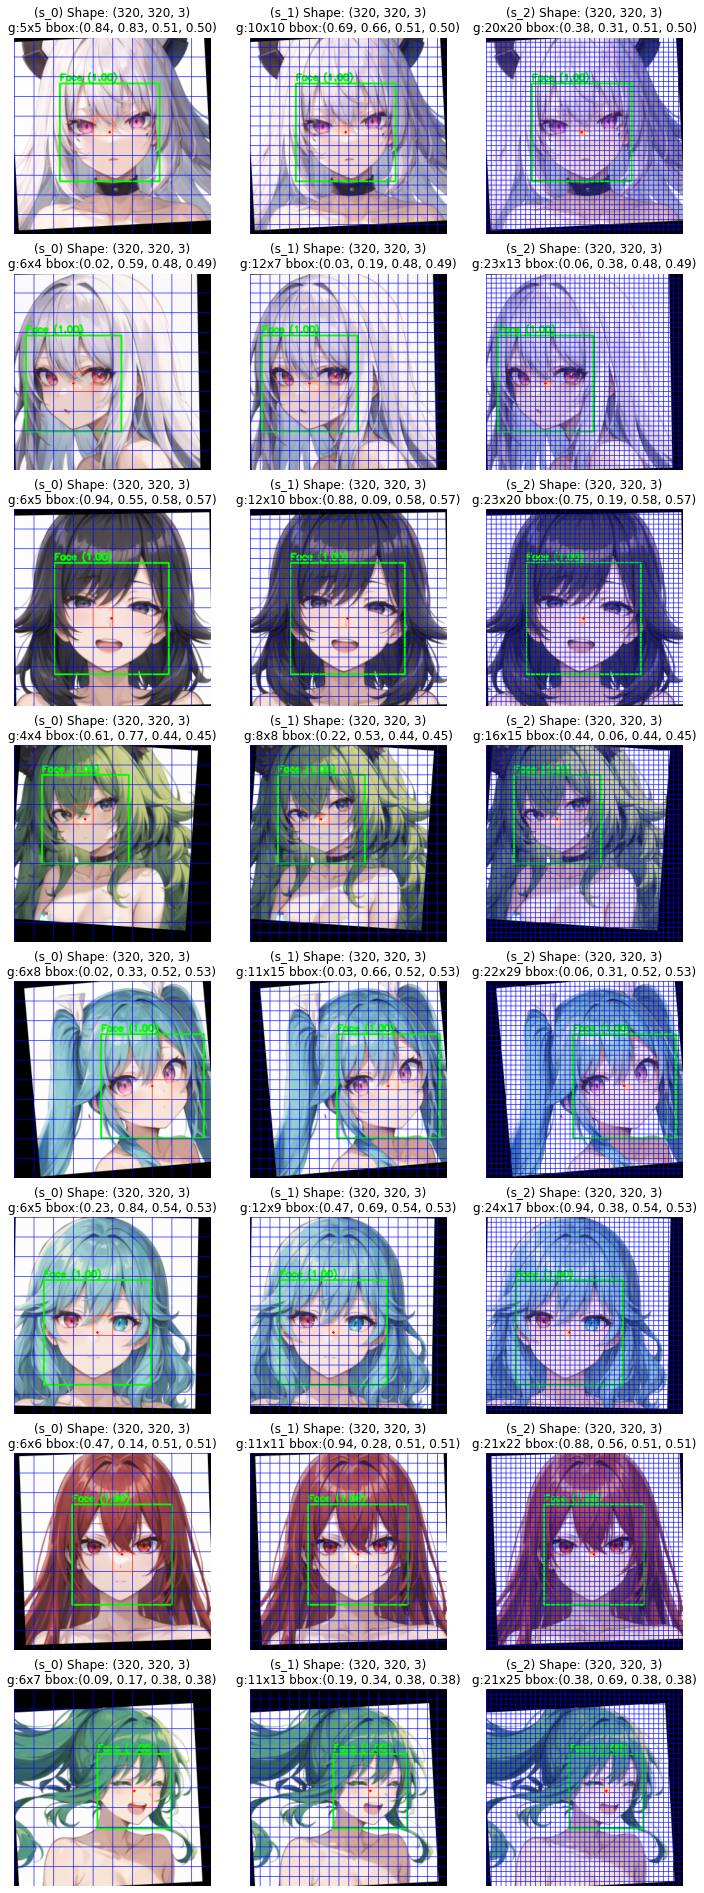

In [5]:
from module.object_detection.YOLOv3DataGenerator import YOLOv3DataGenerator
from module.object_detection.YOLOv3Visualizer import YOLOv3Visualizer

data_generator = YOLOv3DataGenerator(
    input=path_list,
    label_list=CFG["label"],
    image_size=CFG["image_size"], 
    num_anchor=CFG["anchor"], 
    horizontal_flip=True, 
    vertical_flip=False, 
    translate_range=0.1, 
    rotation_range=5,
)

dataset = data_generator.generate_dataset(
    batch_size=CFG["batch"],
    drop_reminder=True,
)

visualizer = YOLOv3Visualizer(CFG["label"])
visualizer.display_batch(dataset, figsize=(12, 34), show_grid=True, show_highlight=True)

## Model creation

In [6]:
from model.YOLOv3 import YOLOv3

yolo = YOLOv3(
    image_size = CFG["image_size"], 
    num_anchor = CFG["anchor"], 
    num_class = len(CFG["label"]),
)

yolo.summary()

Model: "YOLOv3_320x320_a1_1Class"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_image (InputLayer)        [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 896         Input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 320, 320, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________

## Model training

### Main training

In [7]:
from loss.YOLOLoss import YOLOLoss
#from metric.MeanAveragePrecision import MeanAveragePrecision as mAP

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0.1, 
    patience=10, 
    restore_best_weights=False, 
    verbose=1,
)

yolo.compile(
    optimizer = CFG["optimizer1"],
    loss = YOLOLoss(),
    metrics = [], #metrics = [mAP(num_class=len(CFG["label"]))],
)
yolo.train(dataset, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
20/20 [==============================] - 28s 322ms/step - loss: 11.9280 - small_loss: 5.7787 - medium_loss: 3.5155 - large_loss: 2.6337
Epoch 2/1000
20/20 [==============================] - 10s 324ms/step - loss: 7.2172 - small_loss: 3.6153 - medium_loss: 1.9890 - large_loss: 1.6130
Epoch 3/1000
20/20 [==============================] - 10s 324ms/step - loss: 5.6192 - small_loss: 2.7402 - medium_loss: 1.5986 - large_loss: 1.2805
Epoch 4/1000
20/20 [==============================] - 11s 330ms/step - loss: 4.2501 - small_loss: 1.9164 - medium_loss: 1.2562 - large_loss: 1.0774
Epoch 5/1000
20/20 [==============================] - 11s 330ms/step - loss: 3.1976 - small_loss: 1.1915 - medium_loss: 1.0231 - large_loss: 0.9830
Epoch 6/1000
20/20 [==============================] - 11s 331ms/step - loss: 2.6970 - small_loss: 0.9682 - medium_loss: 0.8543 - large_loss: 0.8745
Epoch 7/1000
20/20 [==============================] - 11s 331ms/step - loss: 7.1202 - small_loss: 5.4833 - medi

### Fine tuning 1

In [8]:
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0.05, 
    patience=10, 
    restore_best_weights=False, 
    verbose=1,
)

yolo.compile(
    optimizer = CFG["optimizer2"],
    loss = YOLOLoss(),
    metrics = [], #metrics = [mAP(num_class=len(CFG["label"]))],
)

yolo.train(dataset, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 46
Epoch 47/1000
20/20 [==============================] - 26s 340ms/step - loss: 0.6154 - small_loss: 0.1468 - medium_loss: 0.1911 - large_loss: 0.2775
Epoch 48/1000
20/20 [==============================] - 12s 338ms/step - loss: 0.7277 - small_loss: 0.2699 - medium_loss: 0.1839 - large_loss: 0.2739
Epoch 49/1000
20/20 [==============================] - 12s 342ms/step - loss: 0.5906 - small_loss: 0.1367 - medium_loss: 0.1886 - large_loss: 0.2653
Epoch 50/1000
20/20 [==============================] - 11s 344ms/step - loss: 0.6280 - small_loss: 0.1756 - medium_loss: 0.1829 - large_loss: 0.2695
Epoch 51/1000
20/20 [==============================] - 11s 343ms/step - loss: 0.5346 - small_loss: 0.1262 - medium_loss: 0.1626 - large_loss: 0.2458
Epoch 52/1000
20/20 [==============================] - 12s 341ms/step - loss: 0.5735 - small_loss: 0.1356 - medium_loss: 0.1712 - large_loss: 0.2667
Epoch 53/1000
20/20 [==============================] - 11s 344ms/step - 

### Fine tuning 2

In [9]:
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0.01, 
    patience=10, 
    restore_best_weights=False, 
    verbose=1,
)

yolo.compile(
    optimizer = CFG["optimizer3"],
    loss = YOLOLoss(),
    metrics = [], #metrics = [mAP(num_class=len(CFG["label"]))],
)
yolo.train(dataset, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 61
Epoch 62/1000
20/20 [==============================] - 27s 349ms/step - loss: 0.5248 - small_loss: 0.1193 - medium_loss: 0.1473 - large_loss: 0.2582
Epoch 63/1000
20/20 [==============================] - 12s 344ms/step - loss: 0.5266 - small_loss: 0.1207 - medium_loss: 0.1549 - large_loss: 0.2509
Epoch 64/1000
20/20 [==============================] - 12s 344ms/step - loss: 0.5138 - small_loss: 0.1139 - medium_loss: 0.1591 - large_loss: 0.2409
Epoch 65/1000
20/20 [==============================] - 11s 343ms/step - loss: 0.4976 - small_loss: 0.1089 - medium_loss: 0.1497 - large_loss: 0.2391
Epoch 66/1000
20/20 [==============================] - 11s 336ms/step - loss: 0.5262 - small_loss: 0.1213 - medium_loss: 0.1580 - large_loss: 0.2469
Epoch 67/1000
20/20 [==============================] - 11s 338ms/step - loss: 0.5287 - small_loss: 0.1263 - medium_loss: 0.1571 - large_loss: 0.2454
Epoch 68/1000
20/20 [==============================] - 11s 340ms/step - 

## Export model

In [10]:
yolo.save()

c:\Users\Cattypkung\miniconda3\envs\tf2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## History graph

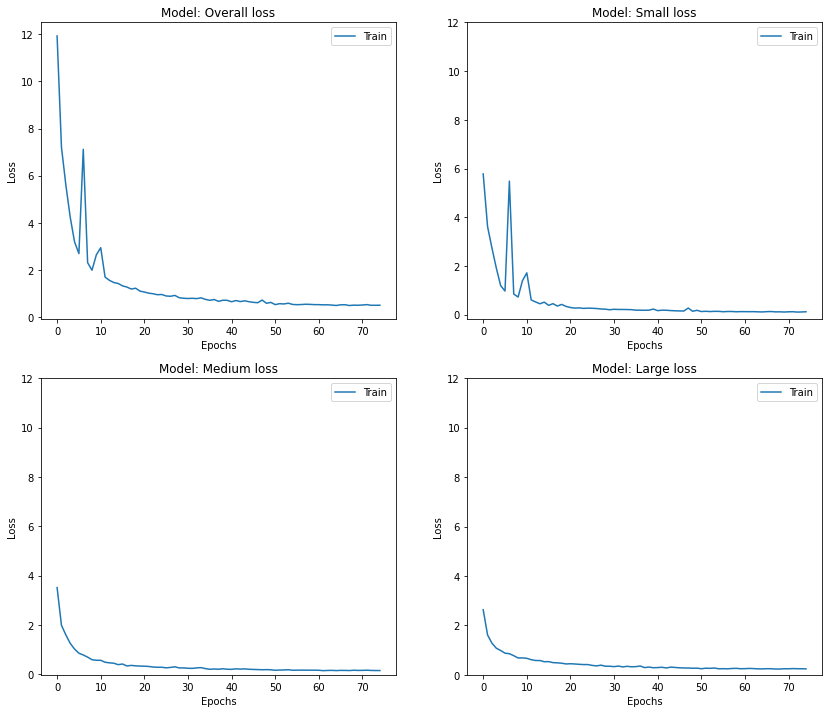

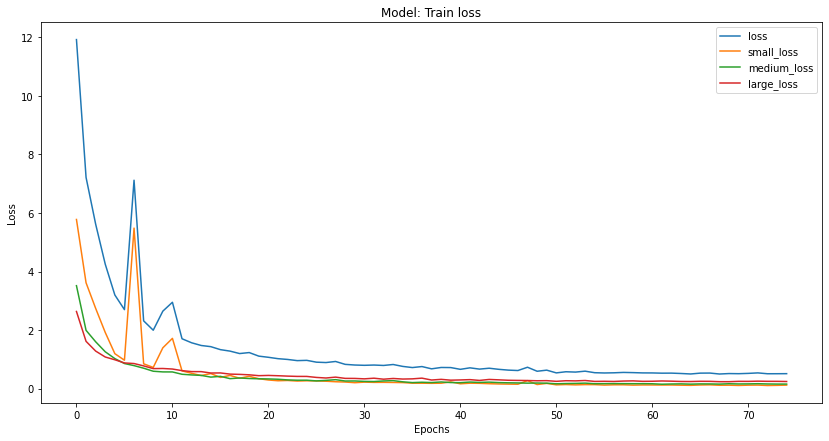

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    loss_list = ["loss", "small_loss", "medium_loss", "large_loss"]
    loss_title = ["Overall loss", "Small loss", "Medium loss", "Large loss"]

    plt.figure(figsize=(14, 12))
    for idx, loss_type in enumerate(loss_list):
        plt.subplot(2, 2, idx + 1)
        plt.plot(history.history[loss_type])
        if f'val_{loss_type}' in history.history:
            plt.plot(history.history[f'val_{loss_type}'])
        plt.title(f'Model: {loss_title[idx]}')
        plt.yticks([0, 2, 4, 6, 8, 10, 12])
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Validation'], loc='upper right')

    plt.figure(figsize=(14, 7))
    for loss_type in loss_list:    
        plt.plot(history.history[loss_type])
        if f'val_{loss_type}' in history.history:
            plt.plot(history.history[f'val_{loss_type}'])
    plt.title(f'Model: Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loss_list, loc='upper right')

plot_training_history(yolo.history)